In [1]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from random import shuffle
import datetime

import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import OneHotEncoder
import xgboost
from catboost import CatBoostClassifier, Pool # cat_features parametr !

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as smon
from scipy import stats

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

import warnings

In [2]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
img_path = "swinyseg/images"
mask_path = "swinyseg/GTmaps"

In [4]:
train_img_lst = os.listdir(img_path)
train_mask_lst = os.listdir(mask_path)

In [5]:
sorted_train_img_lst = sorted(train_img_lst)
sorted_train_mask_lst = sorted(train_mask_lst)
ds_zipped = list(zip(sorted_train_img_lst, sorted_train_mask_lst))
shuffle(ds_zipped)
sorted_train_img_lst, sorted_train_mask_lst = map(list, zip(*ds_zipped[:500]))

In [6]:
train_images, test_images, train_masks, test_masks = train_test_split(
    sorted_train_img_lst, sorted_train_mask_lst, test_size=0.2, shuffle=True
)

In [7]:
train_images

['d0591.jpg',
 'd0129_3.jpg',
 'd0740_5.jpg',
 'd0033_5.jpg',
 'd0308.jpg',
 'd0453_3.jpg',
 'd0465_1.jpg',
 'd0580_1.jpg',
 'd0565_5.jpg',
 'd0777.jpg',
 'd0953_2.jpg',
 'd0638_5.jpg',
 'd0861.jpg',
 'd0822.jpg',
 'd0986_5.jpg',
 'd0251_1.jpg',
 'd0014_1.jpg',
 'd0967.jpg',
 'd0655_3.jpg',
 'd0717_4.jpg',
 'd0107_4.jpg',
 'd0612_1.jpg',
 'd0643_1.jpg',
 'd0720.jpg',
 'd0301_4.jpg',
 'd0210_2.jpg',
 'd0360_2.jpg',
 'd0816_2.jpg',
 'd0375_5.jpg',
 'd0936_5.jpg',
 'd0895_4.jpg',
 'd0806_2.jpg',
 'd0534_3.jpg',
 'd0016_3.jpg',
 'd0682_1.jpg',
 'd0369_2.jpg',
 'd0291_1.jpg',
 'd0750.jpg',
 'd0237_4.jpg',
 'd0738_2.jpg',
 'd0895_3.jpg',
 'd0750_5.jpg',
 'd0376_4.jpg',
 'd0816_1.jpg',
 'd0534_5.jpg',
 'd0604_1.jpg',
 'd0187_1.jpg',
 'd0086_4.jpg',
 'd0095_4.jpg',
 'n0036_3.jpg',
 'd0683_3.jpg',
 'd0498_2.jpg',
 'd0334_5.jpg',
 'd0545.jpg',
 'd0856_2.jpg',
 'd0909_2.jpg',
 'd0941_5.jpg',
 'd0423_2.jpg',
 'n0073_3.jpg',
 'd0761_2.jpg',
 'd0961_2.jpg',
 'n0021_1.jpg',
 'd0848_5.jpg',
 'd0539.jp

In [8]:
test_images

['d1007_1.jpg',
 'd0402_3.jpg',
 'n0114.jpg',
 'd0111_3.jpg',
 'd0893_3.jpg',
 'd0287.jpg',
 'd0538_1.jpg',
 'n0099_5.jpg',
 'd0936_4.jpg',
 'd0759.jpg',
 'd0142_2.jpg',
 'n0038_1.jpg',
 'd0520_4.jpg',
 'd0908_2.jpg',
 'd0258.jpg',
 'n0092_4.jpg',
 'd0763_4.jpg',
 'd0660_2.jpg',
 'd0278_5.jpg',
 'd0992_1.jpg',
 'd0293_3.jpg',
 'd0825_2.jpg',
 'd0033.jpg',
 'd0391_1.jpg',
 'd0990_1.jpg',
 'd0405_3.jpg',
 'd0984_2.jpg',
 'd0932_1.jpg',
 'd0350_3.jpg',
 'd0927_3.jpg',
 'd0735_1.jpg',
 'd0221_1.jpg',
 'd0330_2.jpg',
 'd0366_2.jpg',
 'd0070_5.jpg',
 'd0812_4.jpg',
 'd0430_5.jpg',
 'd0910_3.jpg',
 'd0791_1.jpg',
 'd0981_3.jpg',
 'n0067_4.jpg',
 'n0028_3.jpg',
 'd0244_4.jpg',
 'd0148.jpg',
 'd0629_1.jpg',
 'd0211_1.jpg',
 'd0112_3.jpg',
 'd0860_4.jpg',
 'd0523_3.jpg',
 'n0098_3.jpg',
 'd0808_5.jpg',
 'd0020_1.jpg',
 'd0842_3.jpg',
 'd0916_4.jpg',
 'd0952.jpg',
 'd0508_5.jpg',
 'd0289_4.jpg',
 'd1006_5.jpg',
 'd0360_1.jpg',
 'd0134_4.jpg',
 'd0805_5.jpg',
 'd0206_2.jpg',
 'd0711_5.jpg',
 'd061

swinyseg/images\n0076_2.jpg
(300, 300)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


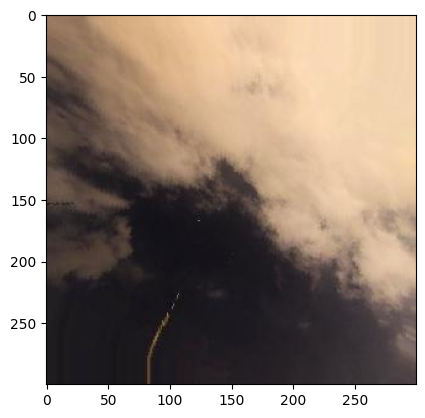

swinyseg/GTmaps\n0076_2.png
(300, 300)


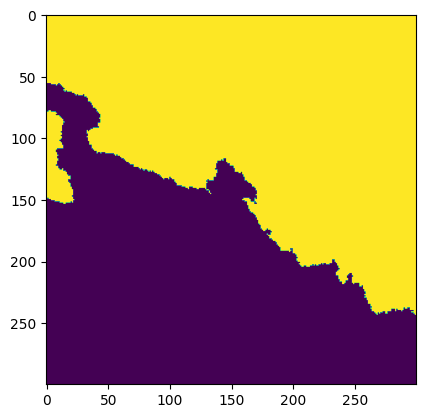

----------------------------------------------------
swinyseg/images\d0626.jpg
(300, 300)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


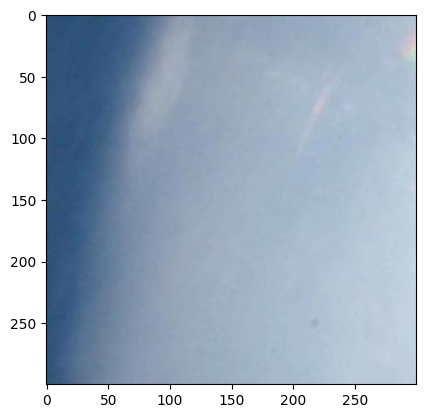

swinyseg/GTmaps\d0626.png
(300, 300)


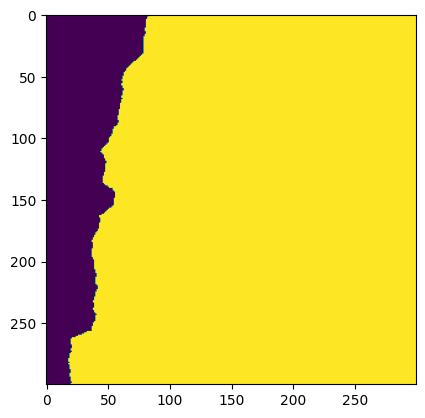

----------------------------------------------------


In [9]:
def show_images(imgs_lst, masks_lst, img_root, mask_root):
    for i in range(len(imgs_lst)):
        img_path = os.path.join(img_root, imgs_lst[i])
        mask_path = os.path.join(mask_root, masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst[-2:], sorted_train_mask_lst[-2:], img_path, mask_path)

In [10]:
class CloudDataset(Dataset):
    def __init__(self, img_list, mask_list, img_root, mask_root, transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        self.img_root = img_root
        self.mask_root = mask_root
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_root, self.img_list[index])
        mask_path = os.path.join(self.mask_root, self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        
        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            
        return img, mask

In [11]:
train_transform = A.Compose([A.Resize(300, 300), 
                             A.Rotate(limit=15, p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value=255),
                             ToTensorV2()])

test_transform = A.Compose([A.Resize(300, 300),
                           A.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value=255),
                           ToTensorV2()])

In [12]:
train_dataset = CloudDataset(train_images, train_masks, img_path, mask_path, transform=train_transform)
test_dataset = CloudDataset(test_images, test_masks, img_path, mask_path, transform=test_transform)

In [13]:
def show_single_img(img=None, mask=None, index=None, train=True):
    if index:
        if train:
            img, mask = train_dataset[index]
        else:
            img, mask = test_dataset[index]
    if (img is not None) and (mask is not None):
        plt.imshow(img.permute(1,2,0), cmap="gray")  # Convert (3, 572, 572) -> (572, 572, 3)
        plt.show()
        plt.imshow(mask.permute(1,2,0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
        print(mask.shape)
        plt.show()
    else:
        return None

---------------Train---------------


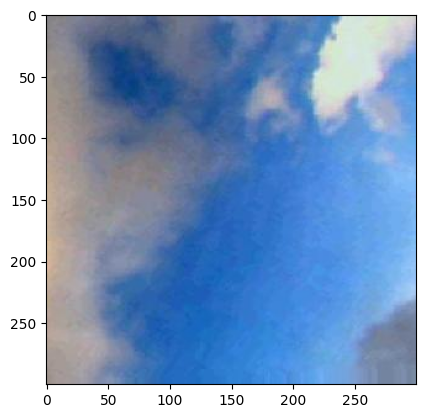

torch.Size([1, 300, 300])


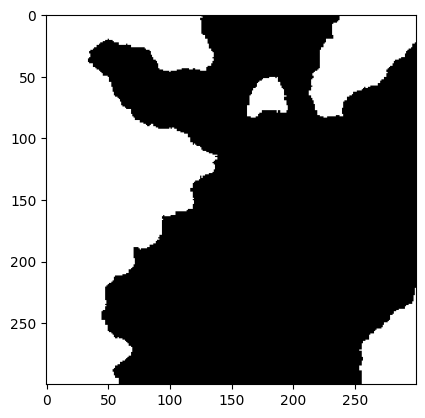

---------------Validation---------------


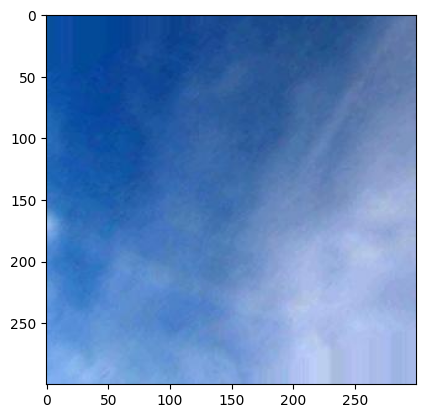

torch.Size([1, 300, 300])


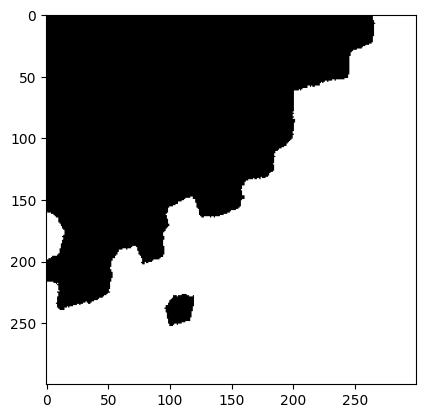

In [14]:
print("---------------Train---------------")
show_single_img(index=1, train=False)
print("---------------Validation---------------")
show_single_img(index=1, train=True)

In [15]:
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

    
def padder(left_tensor, right_tensor): 
    # left_tensor is the tensor on the encoder side of UNET
    # right_tensor is the tensor on the decoder side  of the UNET
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls, out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64, out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128, out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256, out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512, out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        
        # encoding
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
        #print(conv_1x1.shape)

In [17]:
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        train_running_loss += loss.item() * batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

In [18]:
def val_model(model,dataloader,criterion,optimizer):
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * batch_size
            
        val_loss = val_running_loss / (j+1)
    return val_loss

In [19]:
model = UNET(in_chnls = 3, n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 3e-4)
criterion = nn.BCEWithLogitsLoss()
train_loss_lst = []
test_loss_lst = []  

In [ ]:
epochs = 50
min_val = 100000
VAL_FILE = "val_unet_scratch.pth"
for i in tqdm(range(epochs)):
    train_loss = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    test_loss = val_model(model=model,dataloader=test_dataloader,criterion=criterion,optimizer=optimizer)
    if test_loss < min_val:
        min_val = test_loss
        torch.save(model.state_dict(), VAL_FILE)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {test_loss:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.7183
 Validation Loss : 0.7860


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.6226
 Validation Loss : 0.6155


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.6433
 Validation Loss : 1.1273


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.6431
 Validation Loss : 0.6683


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.6322
 Validation Loss : 0.9387


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.6304
 Validation Loss : 0.9828


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.6139
 Validation Loss : 1.2636


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.6157
 Validation Loss : 1.2979


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.5950
 Validation Loss : 1.1600


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.5687
 Validation Loss : 1.3352


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.5981
 Validation Loss : 1.4494


  0%|          | 0/200 [00:00<?, ?it/s]

In [66]:
#TRAINED_FILE = "unet_scratch.pth"
#torch.save(model.state_dict(), TRAINED_FILE)

In [32]:
TRAINED_FILE = "unet_scratch.pth"
trained_model = UNET(in_chnls = 3, n_classes = 1)
trained_model.load_state_dict(torch.load(TRAINED_FILE, map_location="cpu"))
trained_model = trained_model.to(device)
trained_model.eval()

C:\Users\yayahearts\AppData\Local\Temp\ipykernel_20344\3855775855.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(TRAINED_FILE, 

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

-------Original Image-------


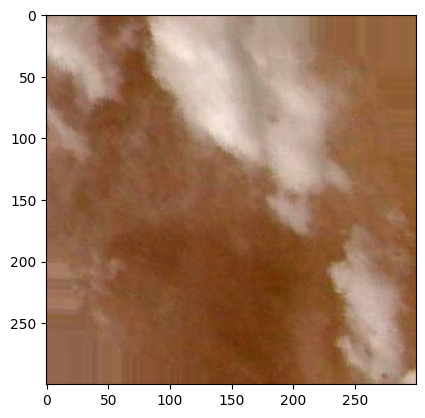

-------Image Mask-------


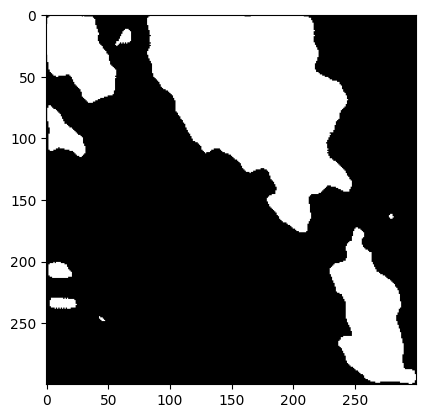

In [37]:
img = cv2.imread(os.path.join(img_path, 'd0001_4.jpg')) #['d0001_4.jpg', 'd0001.jpg']
test_image = test_transform(image = img)
img = test_image["image"].unsqueeze(0)
img = img.to(device)
pred = trained_model(img)

mask = pred.squeeze(0).cpu().detach().numpy()
mask = mask.transpose(1,2,0)

display_test_img = test_image["image"].cpu().detach().numpy()
display_test_img = display_test_img.transpose(1,2,0)

mask[mask <= 1]=0
mask[mask > 1]=1

print("-------Original Image-------")
plt.imshow(display_test_img, cmap="gray")
plt.show()
print("-------Image Mask-------")
plt.imshow(mask,cmap="gray")
plt.show()